# AN2DL Homework 1

In [ ]:
!pip install keras-cv -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 43.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [240]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Nov 24 21:07:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              35W /  70W |  14083MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [269]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import keras_cv
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation, LayerNormalization, Input, GroupNormalization
from tensorflow.keras.optimizers import Adam, AdamW, Adamax
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, ResNet101, NASNetMobile, NASNetMobile, InceptionV3, InceptionResNetV2, VGG16, VGG19, Xception
from tensorflow.keras.metrics import AUC, Recall, Precision, F1Score
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras import layers

from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

from collections import Counter

np.random.seed(42)
tf.random.set_seed(42)

In [270]:
data = np.load('/content/drive/MyDrive/Colab Notebooks/an2dl/training_set.npz')
X = data['images']
y = data['labels']

In [271]:
print(X.shape)
print(y.shape)

(13759, 96, 96, 3)
(13759, 1)


# Data Viz

In [272]:
class_labels = {
    0: 'Basophil',
    1: 'Eosinophil',
    2: 'Erythroblast',
    3: 'Immature granulocytes',
    4: 'Lymphocyte',
    5: 'Monocyte',
    6: 'Neutrophil',
    7: 'Platelet'
}

img_dict = {c: X[y[:,0] == c] for c in range(8)}

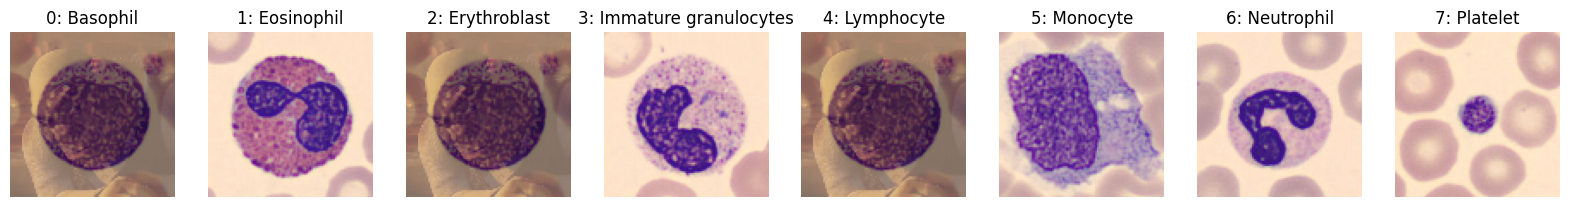

In [273]:
fig, axs = plt.subplots(1, 8, figsize=(20, 5))

for i, label in enumerate(img_dict):
    index = np.random.randint(0, len(img_dict[label]))
    axs[i].imshow(img_dict[label][index])
    axs[i].set_title(f'{label}: {class_labels[label]}')
    axs[i].axis('off')
plt.show()

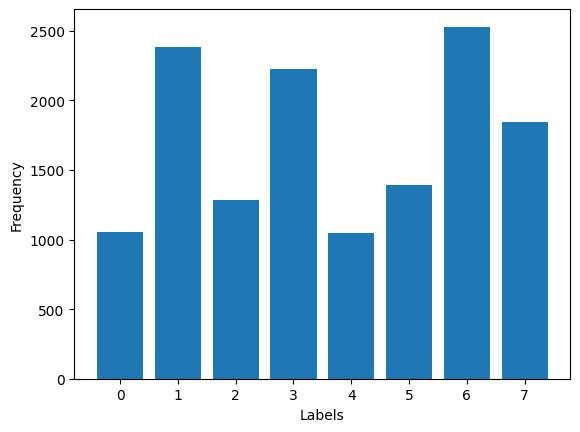

In [274]:
label_counts = Counter(y[:, 0])
plt.bar(label_counts.keys(), np.array(list(label_counts.values())))
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()

# Preprocessing Dataset

In [ ]:
def remove_duplicates(X, y):
    indexes = np.unique(X, axis=0, return_index=True)[1]

    X = np.array([X[index] for index in sorted(indexes)])
    y = np.array([y[index][0] for index in sorted(indexes)])
    return X, y

In [ ]:
X, y = remove_duplicates(X, y)

# remove shrek and rickrolls
X = X[:-2]
y = y[:-2]

In [ ]:
num_classes = len(set(y))
unique_classes = np.unique(y)

In [ ]:
print(X.shape)
print(y.shape)

(11951, 96, 96, 3)
(11951,)


In [ ]:
def remove_outliers(X, y, classes, alpha=3):
    non_outlier_mask = np.ones(y.shape[0], dtype=bool)

    for class_label in classes:
        class_indices = (y == class_label)
        X_class = X[class_indices]
        y_class = y[class_indices]

        pixel_means = np.mean(X_class, axis=(1, 2, 3))  # Mean of each image
        pixel_stds = np.std(X_class, axis=(1, 2, 3))    # Standard deviation of each image

        # Define thresholds for identifying outliers for the current class
        mean_threshold_low = pixel_means.mean() - alpha * pixel_means.std()
        mean_threshold_high = pixel_means.mean() + alpha * pixel_means.std()

        std_threshold_low = pixel_stds.mean() - alpha * pixel_stds.std()
        std_threshold_high = pixel_stds.mean() + alpha * pixel_stds.std()

        # Identify outliers based on these thresholds
        non_outliers = (pixel_means >= mean_threshold_low) & (pixel_means <= mean_threshold_high) & \
                       (pixel_stds >= std_threshold_low) & (pixel_stds <= std_threshold_high)

        non_outlier_mask[class_indices] = non_outliers

    return X[non_outlier_mask], y[non_outlier_mask]


In [ ]:
X_cleaned, y_cleaned = remove_outliers(X, y, unique_classes)

print(X_cleaned.shape)
print(y_cleaned.shape)

(11769, 96, 96, 3)
(11769,)


In [ ]:
y_one_hot = to_categorical(y_cleaned, num_classes)

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_one_hot, test_size=0.2,
                                                    stratify=y_one_hot, random_state=43)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,
                                                stratify=y_test, random_state=43)

# Data Augmentation

In [ ]:
augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomBrightness(0.1, value_range=(0, 1)),
    layers.RandomContrast(0.1),
], name='AugmentationLayer')

In [ ]:
augmix = keras_cv.layers.AugMix(value_range=[0, 255], severity=0.3, num_chains=5, chain_depth=5, alpha = 10, seed=42)
randaug = keras_cv.layers.RandAugment(value_range=[0, 255], augmentations_per_image=3, magnitude=0.01, magnitude_stddev=0.2, rate=10/11, seed=42)

In [ ]:
augmix_images = augmix(X_train)

In [ ]:
randaug_images = randaug(X_train)

In [ ]:
augmix_images = augmix_images.numpy().astype('uint8')
randaug_images = randaug_images.numpy().astype('uint8')

In [ ]:
def add_gaussian_noise(images, std=50):
    noise = np.random.normal(0, std, images.shape)
    im = np.clip(images + noise, 0, 255)
    return im.astype(np.uint8)

In [ ]:
augmix_noisy = np.array([add_gaussian_noise(img) for img in augmix_images])
rand_aug_noisy = np.array([add_gaussian_noise(img) for img in randaug_images])
# train_noisy = np.array([add_gaussian_noise(img) for img in X_train])

Since we are inputting two augmented and noisy versions of the training data to help with generalization, we considered inputting the original, unaltered
X_train without noise to help the model better learn the underlying patterns in the data.

In [ ]:
augmented_train = np.concatenate([augmix_noisy, rand_aug_noisy, X_train], axis=0)
augmented_labels = np.concatenate([y_train] * 3, axis=0)

In [ ]:
X_train_augmented, y_train_augmented = shuffle(augmented_train, augmented_labels, random_state=42)

Shuffling is used here to avoid getting the same kind of data in the same batch.

In [ ]:
X_train_augmented = X_train_augmented / 255.
X_val = X_val / 255.
X_test = X_test / 255.

Due to our imbalanced dataset, we chose to use class_weights to aprevent the model from favoring the over-represented classes.

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_augmented.argmax(axis=1)), y=y_train_augmented.argmax(axis=1))
class_weights_dict = dict(enumerate(class_weights))

# Modeling

In [ ]:
input_shape = (96, 96, 3)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=3,
    min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

checkpoint_callback = ModelCheckpoint(filepath='weights.keras',
                                      monitor='val_loss',
                                      save_best_only=True,
                                      mode='min',
                                      verbose=1)

callbacks = [lr_scheduler, early_stopping, checkpoint_callback]

We have chosen to use a decreasing learning rate for the training: This prevents the model from being a slow-learner at the beginning and it also helps it close in on the solution at the end.

Early stopping is used to stop the training if the model is overfitting and the model is saved automatically anytime the validation loss decreases.

In [ ]:
def build_model(base_model, input_shape, num_classes, augmentation=None, normalization='batch', l2=None):
    if l2:
        for layer in base_model.layers:
            if hasattr(layer, 'kernel_regularizer'):
                layer.kernel_regularizer = keras.regularizers.l2(l2)

    inputs = Input(shape=input_shape, name='custom_input_layer')
    if augmentation:
        x = augmentation(inputs)
    else:
        x = inputs

    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(l2))(x)

    if normalization == "batch":
        x = BatchNormalization()(x)
    elif normalization == "group":
        x = GroupNormalization(groups=32)(x)
    elif normalization == "layer":
        x = LayerNormalization()(x)

    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)

    return model


def eval_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    if y_pred.ndim == 2:
        y_pred = np.argmax(y_pred, axis=1)

    if y_test.ndim == 2:
        y_true = np.argmax(y_test, axis=1)
    else:
        y_true = y_test

    acc = accuracy_score(y_true, y_pred)
    print('Accuracy score:', acc)
    print(classification_report(y_true, y_pred))

    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return acc

We have found that the accuracy increases when the augmentation layer is wrapped inside a keras model thus we added it before the base model (in this case resnet50) and we also added a couple of extra layers to adapt the model to our custom output of 8 classes.

This adaptation is needed in the case where the imagenet weights are to be kept which is our case

### ResNet

In [ ]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
resnet_clf = build_model(resnet, input_shape, num_classes, augmentation=augmentation, normalization='layer', l2=0.05)
resnet_clf.summary()

resnet_clf.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy'] ,
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ custom_input_layer (InputLayer)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ AugmentationLayer (Sequential)       │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 3, 3, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 1024)                │           2,048 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           8,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,696,136 (98.02 MB)

 Trainable params: 25,643,016 (97.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
history = resnet_clf.fit(
    X_train_augmented,
    y_train_augmented,
    batch_size=32,
    epochs=100,
    validation_data = (X_val, y_val),
    class_weight=class_weights_dict,
    callbacks=callbacks
)

Epoch 1/100
883/883 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.6600 - loss: 1.2054
Epoch 1: val_loss improved from inf to 1.35636, saving model to /content/drive/MyDrive/Colab Notebooks/an2dl/best_model13.keras
883/883 ━━━━━━━━━━━━━━━━━━━━ 173s 155ms/step - accuracy: 0.6601 - loss: 1.2050 - val_accuracy: 0.5446 - val_loss: 1.3564 - learning_rate: 5.0000e-04
Epoch 2/100
883/883 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8422 - loss: 0.4708
Epoch 2: val_loss improved from 1.35636 to 0.21755, saving model to /content/drive/MyDrive/Colab Notebooks/an2dl/best_model13.keras
883/883 ━━━━━━━━━━━━━━━━━━━━ 130s 147ms/step - accuracy: 0.8422 - loss: 0.4708 - val_accuracy: 0.9252 - val_loss: 0.2176 - learning_rate: 5.0000e-04
Epoch 3/100
883/883 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8596 - loss: 0.4178
Epoch 3: val_loss did not improve from 0.21755
883/883 ━━━━━━━━━━━━━━━━━━━━ 128s 145ms/step - accuracy: 0.8596 - loss: 0.4178 - val_accuracy: 0.9116 - val_loss: 0.3294 - learn

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Accuracy score: 0.9830076465590484
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        84
           1       1.00      1.00      1.00       214
           2       0.97      0.98      0.98       106
           3       0.97      0.97      0.97       199
           4       0.99      0.95      0.97        83
           5       0.95      0.99      0.97        99
           6       0.99      0.98      0.98       230
           7       1.00      0.99      0.99       162

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



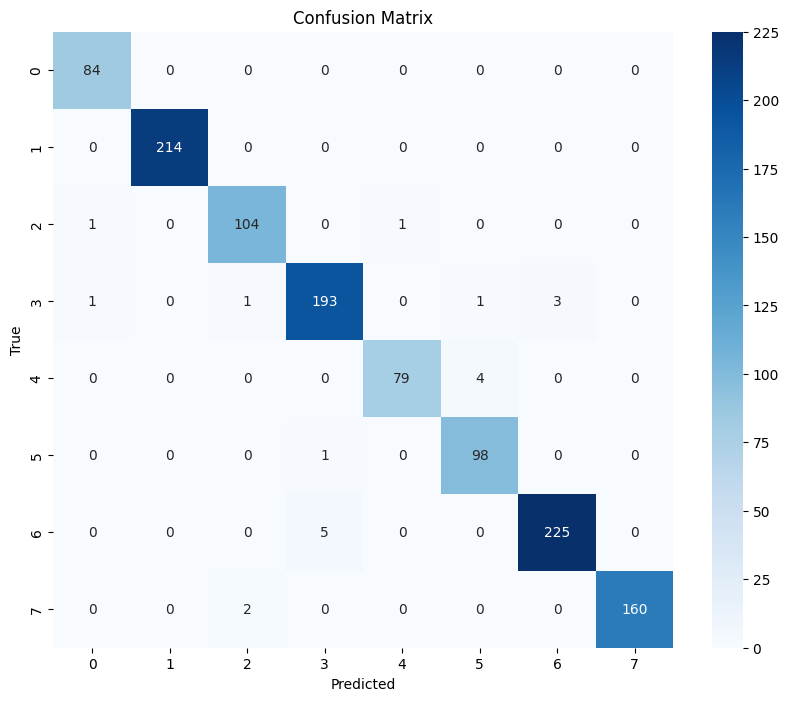

In [ ]:
acc = eval_model(resnet_clf, X_test/255, y_test)

The model reaches an accuracy of 98% on both the validation and the test sets. The macro F1 score has a 98% value as well which shows that the model is accurate even on classes that are under-represented. This is backed with the confusion matrix that shows that the model is almost perfect on all classes.

We observe that the training accuracy is slightly lower than both the validation and test accuracies. This can be explained by the fact that the training set includes augmented images that are particularly challenging to classify, making a training accuracy of 97% quite impressive.

### Gradcam

In [279]:
resnet_clf = load_model('weights.keras')

In [280]:
def make_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):

    input_layer = model.get_layer("custom_input_layer")
    augmentation_layer = model.get_layer("AugmentationLayer")
    resnet_layer = model.get_layer("resnet50")
    avg_pooling_layer = model.get_layer('global_average_pooling2d')
    dense_layer = model.get_layer('dense')
    layer_norm_layer = model.get_layer('layer_normalization')
    dropout_layer = model.get_layer('dropout')
    dense_1_layer = model.get_layer('dense_1')


    augmentation_output = augmentation_layer.output
    input_layer_output = input_layer.output
    resnet_output = resnet_layer(input_layer_output)
    model_output = dense_1_layer(dropout_layer(layer_norm_layer(dense_layer(avg_pooling_layer(resnet_output)))))

    grad_model = tf.keras.models.Model(
        [model.inputs], [resnet_output, model_output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

import cv2

def display_gradcam(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_VIRIDIS)

    superimposed_img = np.clip(heatmap * alpha + np.uint8(img*255), 0, 255)
    return superimposed_img

In [281]:
img_dict = {c: X_test[y_test.argmax(axis=1)[:] == c] for c in range(8)}

In [284]:
last_conv_layer_name = 'conv5_block3_out'
fig, axs = plt.subplots(8, 5, figsize=(150, 150))

for i, label in enumerate(img_dict):
  for j in range(5):
    index = np.random.randint(0, len(img_dict[label]))
    img = img_dict[label][j]
    img_array = np.expand_dims(img, axis=0)
    heatmap = make_gradcam_heatmap(resnet_clf, img_array, last_conv_layer_name)
    superimposed_img = display_gradcam(img, heatmap, alpha = 0.4)

    axs[i][j].imshow(superimposed_img.astype(np.uint8))
    axs[i][j].set_title(f'Label {label}: prediction {resnet_clf(img_array).numpy().argmax()}', fontsize=80)
    axs[i][j].axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Grad-CAM (Gradient-weighted Class Activation Mapping) is a visualization technique used to interpret the decisions of convolutional neural networks.

Grad-CAM relies on the gradients of the output with respect to the activations in the last convolutional layer.

It is used to see where the CNN models 'look' in order to make a decision.

Since in our case, all the models have convolutional layers, we used it to see if our models are behaving as expected or not.

In the snapshots above, the most important regions of each image are the brightest, and it is clear that in most cases, the model is capable of distinguishing areas that are important to make the decision (mainly looking at the cells).

A thing to keep in mind is that we are adding the heatmap to the image and so empty spots will become a lot brighter compared to the dark cells that a get a little bit brighter. And so if some of the area surrounding the cell is bright, that means that the model is looking at the cell as well.

### Stacking

Stacking is a known strategy where we stack a decision model over our best models. The decision model takes the decisions of all the other models and outputs a final decision.

In our case, we have three models that are clearly better than the rest so we used them ans stacked a fully-connected neural network over them.

In [ ]:
resnet_model = load_model('weights_leaderboard_59.keras')
resnet_model.name = 'resnet_model'
nasnet_model = load_model('weights_leaderboard_62.keras')
nasnet_model.name = 'nasnet_model'
efficient_model = load_model('weights_leaderboard_57.keras')
efficient_model.name = 'efficient_model'

In [ ]:
y_resnet = resnet_model.predict(X_train_augmented)
y_nasnet = nasnet_model.predict(X_train_augmented)
y_efficient = efficient_model.predict(X_train_augmented)

883/883 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step
883/883 ━━━━━━━━━━━━━━━━━━━━ 38s 37ms/step
883/883 ━━━━━━━━━━━━━━━━━━━━ 95s 100ms/step


In [ ]:
stacking_input = np.concatenate([y_resnet, y_nasnet, y_efficient], axis=1)

In [230]:
stacking_model = Sequential()

stacking_model.add(Dense(128, activation='relu', input_shape=(num_classes*3,), kernel_regularizer=keras.regularizers.l2(0.0001)))
stacking_model.add(Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)))
stacking_model.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)))
stacking_model.add(Dense(num_classes, activation='softmax'))

In [231]:
checkpoint_callback = ModelCheckpoint(filepath='stacking_model.keras',
                                      monitor='val_loss',
                                      save_best_only=True,
                                      mode='min',
                                      verbose=1)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [232]:
stacking_model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'],)

stacking_history = stacking_model.fit(stacking_input, y_train_augmented, batch_size=32, epochs=100, validation_split=0.2,callbacks=[checkpoint_callback, early_stopping])

Epoch 1/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8200 - loss: 1.1029
Epoch 1: val_loss improved from inf to 0.20905, saving model to /content/drive/MyDrive/Colab Notebooks/an2dl/stacking_model1.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8201 - loss: 1.1022 - val_accuracy: 0.9439 - val_loss: 0.2090
Epoch 2/100
698/707 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9422 - loss: 0.2152
Epoch 2: val_loss improved from 0.20905 to 0.19927, saving model to /content/drive/MyDrive/Colab Notebooks/an2dl/stacking_model1.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9423 - loss: 0.2151 - val_accuracy: 0.9474 - val_loss: 0.1993
Epoch 3/100
699/707 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9444 - loss: 0.2050
Epoch 3: val_loss improved from 0.19927 to 0.19529, saving model to /content/drive/MyDrive/Colab Notebooks/an2dl/stacking_model1.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9445 - loss: 0.2049 - val_accuracy: 0.9485 - val_

In [285]:
y_resnet_test = resnet_model.predict(X_test)
y_nasnet_test = nasnet_model.predict(X_test)
y_efficient_test = efficient_model.predict(X_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step


In [286]:
stacking_input_test = np.concatenate([y_resnet_test, y_nasnet_test, y_efficient_test], axis=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy score: 0.9847068819031436
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        84
           1       1.00      1.00      1.00       214
           2       1.00      0.99      1.00       106
           3       0.97      0.96      0.97       199
           4       1.00      0.93      0.96        83
           5       0.97      0.99      0.98        99
           6       0.97      0.99      0.98       230
           7       1.00      1.00      1.00       162

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



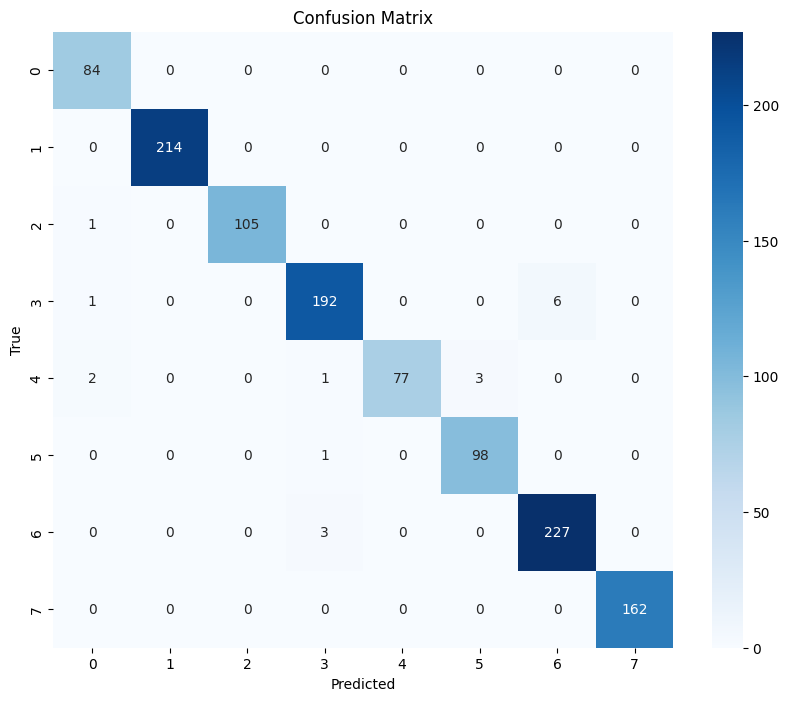

In [288]:
y_pred_probs = stacking_model.predict(stacking_input_test)
y_pred = y_pred_probs.argmax(axis=1)

acc = accuracy_score(y_test.argmax(axis=1), y_pred)
print('Accuracy score:', acc)
print(classification_report(y_test.argmax(axis=1), y_pred))

conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In deed, the stacked model performs better that all the base models as it scores the highest test accuracy and gets the best accuracy on the codabench platform compared to the others.

We attempted to fully build the model and wrap it inside a keras model but there is an error with that that was only fixed in another version of keras, so we decided to run the base models seperately and then run the fully connected model on their outputs.